In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [14]:
data = pd.read_csv('/Users/amulya/Desktop/Capstone/DSCI-601-Amy/Data/f_eng_data_AAPL.csv')

In [15]:
data.columns

Index(['date', 'RET', 'VOL_CHANGE', 'BA_SPREAD', 'ILLIQUIDITY', 'sprtrn',
       'TURNOVER', 'DJI_Return', 'day_of_week', 'day_of_month', 'month',
       'is_month_start', 'is_month_end', 'year', 'week', 'RET_ema_12',
       'RET_ema_26', 'RET_cumulative_sum', 'RET_cumulative_product',
       'RET_skew_10', 'RET_kurtosis_10', 'RET_entropy_10', 'RSI', 'OBV'],
      dtype='object')

## Linear Regression

In [16]:
features = ['RET_ema_12', 'RET_ema_26', 'day_of_week', 'VOL_CHANGE', 'BA_SPREAD', 'DJI_Return','OBV','TURNOVER', 'is_month_start', 'is_month_end']

# Drop rows with missing values in these features
data_modeling = data[features + ['RET']].dropna()

In [17]:
X = data_modeling[features]
y = data_modeling['RET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
y_pred = model.predict(X_test)

In [19]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 0.0004
R-Squared (R2): 0.4334


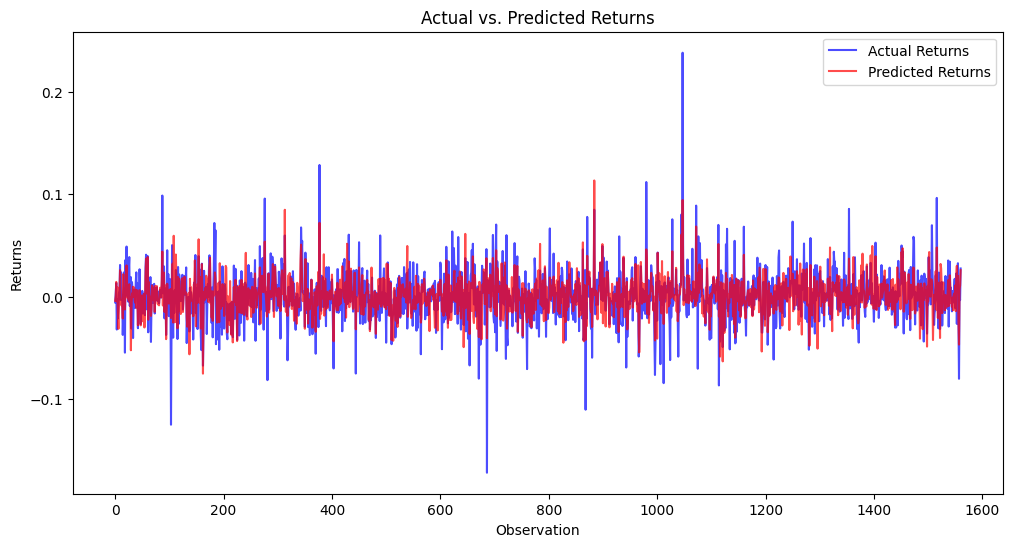

In [20]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, label='Actual Returns', color='blue', alpha=0.7)
plt.plot(results_df['Predicted'].values, label='Predicted Returns', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Returns')
plt.xlabel('Observation')
plt.ylabel('Returns')
plt.legend()
plt.show()

#### Predictions for the next year

In [27]:
data['date'] = pd.to_datetime(data['date'])

future_dates = pd.date_range(start=data['date'].max() + pd.Timedelta(days=1), periods=252, freq='B')  # 'B' = business days
future_df = pd.DataFrame({'date': future_dates})
future_df['day_of_week'] = future_df['date'].dt.dayofweek
future_df['month'] = future_df['date'].dt.month

# For the other features, use historical mean values as placeholders
for feature in features:
    if feature not in ['day_of_week', 'month']:
        future_df[feature] = data[feature].mean()  # Use historical mean as placeholder

future_df

,date,day_of_week,month,RET_ema_12,RET_ema_26,VOL_CHANGE,BA_SPREAD,DJI_Return,OBV,TURNOVER,is_month_start,is_month_end
0,2023-01-02,0,1,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
1,2023-01-03,1,1,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
2,2023-01-04,2,1,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
3,2023-01-05,3,1,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
4,2023-01-06,4,1,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
...,...,...,...,...,...,...,...,...,...,...,...,...
247,2023-12-13,2,12,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
248,2023-12-14,3,12,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
249,2023-12-15,4,12,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436
250,2023-12-18,0,12,0.001207,0.00126,0.091693,0.001461,0.000364,11.40188,18.984199,0.030746,0.033436


In [28]:
# Predict returns for the next year
future_X = future_df[features]
future_df['Predicted_RET'] = model.predict(future_X)

# Display the first few predicted returns
print(future_df[['date', 'Predicted_RET']].head())


        date  Predicted_RET
0 2023-01-02       0.001784
1 2023-01-03       0.001537
2 2023-01-04       0.001290
3 2023-01-05       0.001043
4 2023-01-06       0.000796


# Exponential Soothing

Exponential Smoothing is a time series forecasting method that applies weighted averaging to past observations, giving more importance to recent data points while diminishing the influence of older observations.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [6]:
df = pd.read_csv('/Users/amulya/Desktop/Capstone/DSCI-601-Amy/Data/AKAM.csv')

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [9]:
# Implement Exponential Smoothing with a smoothing factor (alpha)
smoothing_factor = 0.3  # Choose a smoothing factor between 0 and 1

# Calculate Exponential Smoothing - ewm - expo weighted ma
df['Exponential_Smoothing'] = df['PRC'].ewm(alpha=smoothing_factor, adjust=False).mean()

print("Exponential Smoothing of PRC (Stock Prices):")
print(df[['PRC', 'Exponential_Smoothing']])

Exponential Smoothing of PRC (Stock Prices):
                 PRC  Exponential_Smoothing
date                                       
1999-11-01  174.3125             174.312500
1999-11-02  192.7500             179.843750
1999-11-03  190.8750             183.153125
1999-11-04  173.2500             180.182187
1999-11-05  174.2500             178.402531
...              ...                    ...
2023-12-22  119.6200             119.245263
2023-12-26  119.4800             119.315684
2023-12-27  119.0000             119.220979
2023-12-28  119.0200             119.160685
2023-12-29  118.3500             118.917480

[6080 rows x 2 columns]


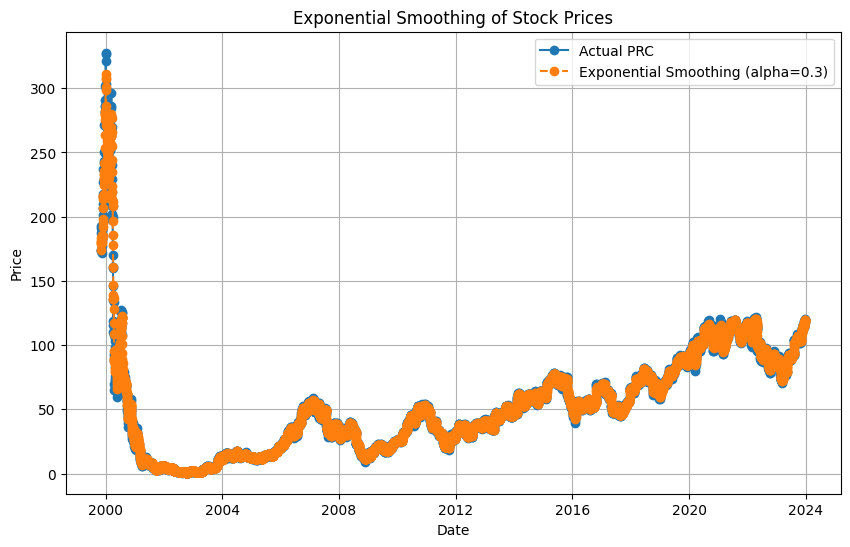

In [10]:
import matplotlib.pyplot as plt

# Plot the actual and smoothed values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['PRC'], marker='o', label='Actual PRC')
plt.plot(df.index, df['Exponential_Smoothing'], marker='o', linestyle='--', label='Exponential Smoothing (alpha=0.3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Exponential Smoothing of Stock Prices')
plt.legend()
plt.grid()
plt.show()


In [13]:
model = ExponentialSmoothing(df['PRC'], trend='additive', seasonal=None, seasonal_periods=None).fit()
forecast = model.forecast(steps=365)


/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


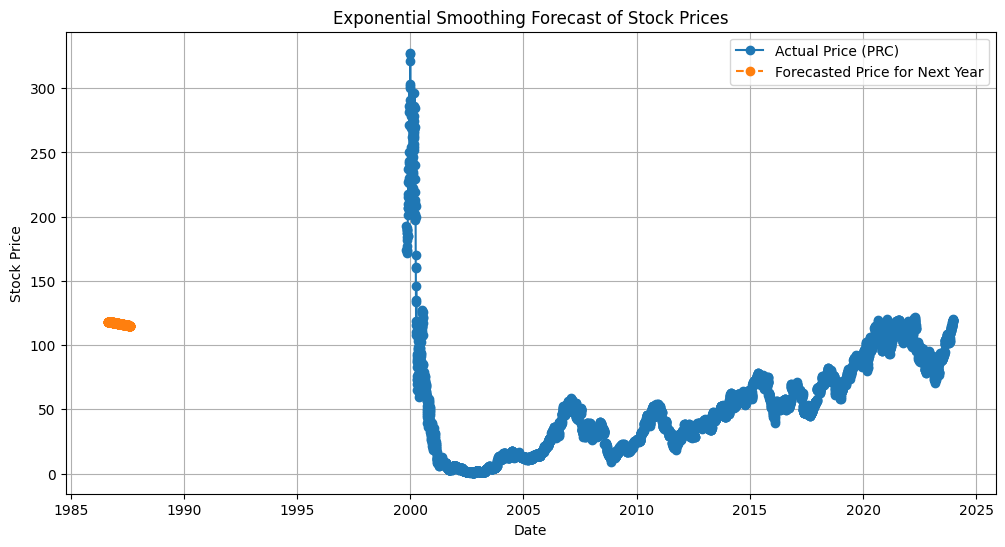

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PRC'], marker='o', label='Actual Price (PRC)')
plt.plot(forecast.index, forecast, marker='o', linestyle='--', label='Forecasted Price for Next Year')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Exponential Smoothing Forecast of Stock Prices')
plt.legend()
plt.grid()
plt.show()


/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


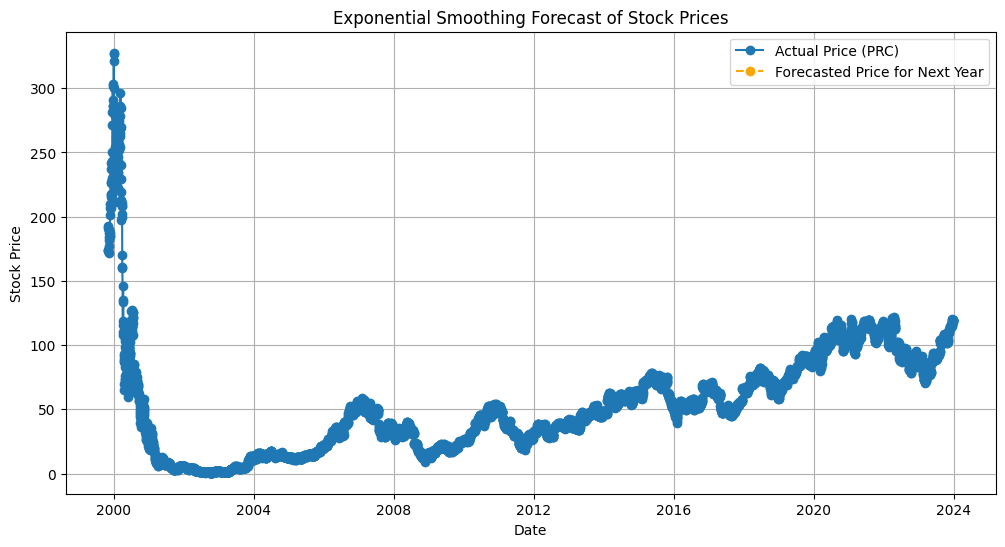

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


data = pd.read_csv('/Users/amulya/Desktop/Capstone/DSCI-601-Amy/Data/AKAM.csv')
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Fit the Holt-Winters Exponential Smoothing Model
model = ExponentialSmoothing(df['PRC'], trend='additive', seasonal=None, seasonal_periods=None).fit()

# Predict prices for the next 365 days (1 year) starting from the last date of the historical data
forecast = model.forecast(steps=365)

# Create a new date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
forecast = pd.Series(forecast, index=forecast_index)


plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PRC'], marker='o', label='Actual Price (PRC)')
plt.plot(forecast.index, forecast, marker='o', linestyle='--', color='orange', label='Forecasted Price for Next Year')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Exponential Smoothing Forecast of Stock Prices')
plt.legend()
plt.grid()
plt.show()


/Users/amulya/Desktop/Capstone/DSCI-601-Amy/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


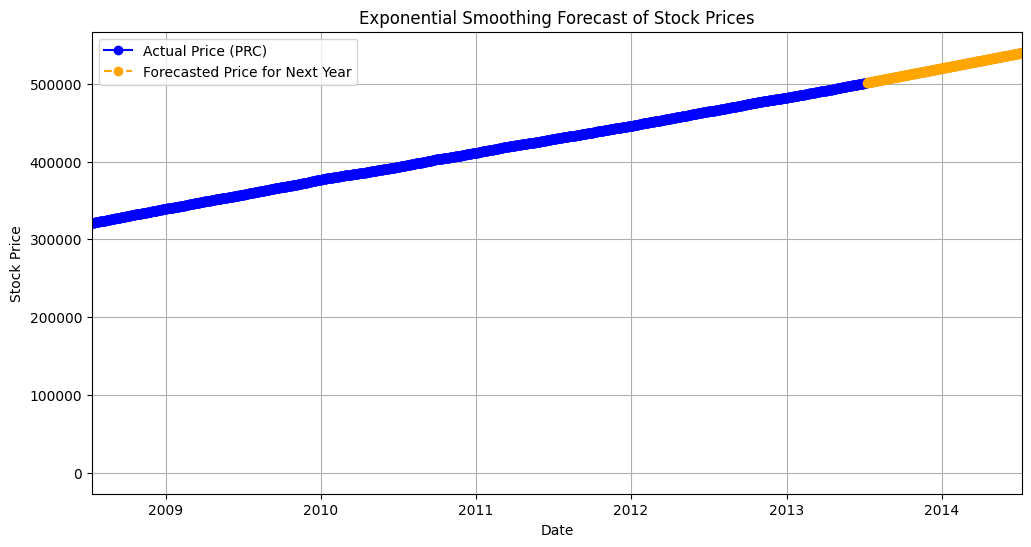

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df = pd.read_csv('/Users/amulya/Desktop/Capstone/DSCI-601-Amy/Data/AKAM.csv')

import numpy as np
np.random.seed(42)
dates = pd.date_range(start='1999-11-01', periods=5000, freq='D')  # Replace with actual date range
prices = np.random.normal(loc=100, scale=50, size=len(dates)).cumsum()  # Synthetic prices, replace with real data
df = pd.DataFrame({'date': dates, 'PRC': prices})
df.set_index('date', inplace=True)

# Fit the Holt-Winters Exponential Smoothing Model on the actual data
model = ExponentialSmoothing(df['PRC'], trend='additive', seasonal=None, seasonal_periods=None).fit()

# Predict prices for the next 365 days (1 year) starting from the last date of the historical data
forecast = model.forecast(steps=365)

# Create a new date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')
forecast = pd.Series(forecast, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PRC'], marker='o', label='Actual Price (PRC)', color='blue')
plt.plot(forecast.index, forecast, marker='o', linestyle='--', color='orange', label='Forecasted Price for Next Year')
plt.xlim([df.index[-365*5], forecast.index[-1]])  # Show only the last 5 years for clarity
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Exponential Smoothing Forecast of Stock Prices')
plt.legend()
plt.grid()
plt.show()
